# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [4]:
from dataloaders import dataset_SparseData
from dataloaders import load_dataset
from loss import losses_SparseData
from models import models_SparseData
from optimizer import load_optimizer

from subprocess import Popen

# Load dictionary

In [5]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/SparseData/SparseData_Transformer_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'Dataset_Sparse', 'piezo_head': True, 'normalization': True, 'target_norm_type': 'overall_zscore', 'date_max_norm': '2017-12-31', 

# Dataset class

In [6]:
ds = dataset_SparseData.Dataset_Sparse(dict_files)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_means': np.float64(298.19569411165224), 'target_stds': np.float64(73.65282819016454), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.35
    tmin         float32 4B 5.037
    tmean        float32 4B 8.694, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    s

In [7]:
ds.wtd_df

wtd       lon       lat    height  nan_mask  \
date       sensor_id                                                        
2000-12-31 00103510001        NaN -0.154105  0.053733 -0.866947     False   
           00104110001        NaN  0.094087  0.202696 -0.951262     False   
           00105110001        NaN  0.518426  0.446357 -1.021212     False   
           00105910001        NaN  0.808310  0.149836 -1.018794     False   
           00105910002        NaN  0.722698  0.233721 -1.028230     False   
...                           ...       ...       ...       ...       ...   
2023-12-24 00417910001   5.068571  0.725215 -0.123456 -0.997253      True   
           00421510001   3.931905  0.642913 -0.516018 -0.929923      True   
           00421710001   6.553762  0.446580 -0.380864 -0.962027      True   
           00422510001  26.085667  0.364473 -0.911923 -0.777247      True   
           00425010001   4.953333  0.463569 -0.751001 -0.852743      True   

                               h  
date       sensor_id              
2000-12-31 00103510001       NaN  
           00104110001       NaN  
           00105110001       NaN  
           00105910001       NaN  
           00105910002       NaN  
...                          ...  
2023-12-24 00417910001 -0.626484  
           00421510001  0.197800  
           00421710001 -0.223473  
           00422510001  1.731121  
           00425010001  1.111101  

[33600 rows x 6 columns]

In [8]:
ds.weather_xr

<xarray.Dataset> Size: 6MB
Dimensions:      (time: 3410, lat: 9, lon: 12)
Coordinates:
  * lon          (lon) float64 96B 6.688 6.813 6.938 7.063 ... 7.813 7.938 8.063
  * lat          (lat) float64 72B 45.31 45.19 45.06 44.94 ... 44.56 44.44 44.31
  * time         (time) datetime64[ns] 27kB 1958-08-24 1958-08-31 ... 2023-12-24
    spatial_ref  int64 8B 0
Data variables:
    prec         (time, lat, lon) float32 1MB -0.6083 -0.6096 ... -0.6293
    tmax         (time, lat, lon) float32 1MB 0.8723 0.9537 ... -0.1744 0.01484
    tmin         (time, lat, lon) float32 1MB 0.1323 0.1569 ... -0.7279 -0.665
    tmean        (time, lat, lon) float32 1MB 0.5023 0.5553 ... -0.4512 -0.3251
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 14 07:41:14 2024: cdo -r settaxis,1957-12-01,12:00,...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [9]:
sample_date = np.datetime64("2000-12-31")
ds.get_target_data(sample_date, sample_date)

(tensor([[ 0.0537, -0.1541, -0.8669,  0.0000],
         [ 0.2027,  0.0941, -0.9513,  0.0000],
         [ 0.4464,  0.5184, -1.0212,  0.0000],
         [ 0.1498,  0.8083, -1.0188,  0.0000],
         [ 0.2337,  0.7227, -1.0282,  0.0000],
         [-0.0779,  0.0140, -0.9516,  0.0000],
         [ 0.8719,  0.4627, -0.9582,  0.0000],
         [ 0.4663,  0.6909, -1.0349,  0.0000],
         [ 0.6315,  0.3695, -0.9801,  0.0000],
         [ 0.3499,  1.0955, -1.0181,  0.0000],
         [ 0.2384,  0.2776, -0.9950,  0.0000],
         [ 0.7390,  0.6502, -1.0053,  0.0000],
         [ 0.8231,  0.7965, -1.0433,  0.0000],
         [ 0.1747,  0.4401, -1.0114,  0.0000],
         [-0.2520, -0.0823, -0.9128,  0.0000],
         [-0.3832,  1.0909, -0.9726,  0.0000],
         [-0.9421,  0.2661, -0.7349,  0.0000],
         [-0.0789,  0.8346, -0.9981,  0.0000],
         [-0.3521,  0.6148, -0.9658, -0.2045],
         [-1.2204,  0.3759, -0.7029,  2.4366],
         [-0.7581,  0.8144, -0.8862,  0.7229],
         [-1.

In [10]:
timestep = 24
print(ds[100][0][timestep+1,:,-1], end = "\n\n")
print(ds[100][3][timestep,:])

tensor([348.2072,   0.0000,   0.0000, 232.4600, 223.8954,   0.0000,   0.0000,
        218.8350,   0.0000,   0.0000, 256.5935, 227.6160,   0.0000,   0.0000,
        321.7438, 274.8842, 436.0776,   0.0000, 282.6330, 476.7404, 351.5629,
          0.0000, 249.2226, 252.4715, 313.1540,   0.0000, 428.7019, 381.0108])

tensor([348.2072,   0.0000,   0.0000, 232.4600, 223.8954,   0.0000,   0.0000,
        218.8350,   0.0000,   0.0000, 256.5935, 227.6160,   0.0000,   0.0000,
        321.7438, 274.8842, 436.0776,   0.0000, 282.6330, 476.7404, 351.5629,
          0.0000, 249.2226, 252.4715, 313.1540,   0.0000, 428.7019, 381.0108])


<Axes: xlabel='wtd', ylabel='Count'>

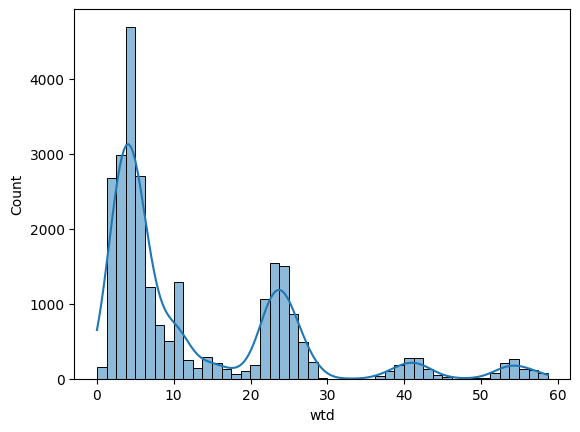

In [10]:
sns.histplot(ds.wtd_df["wtd"], kde=True)

<Axes: xlabel='h', ylabel='Count'>

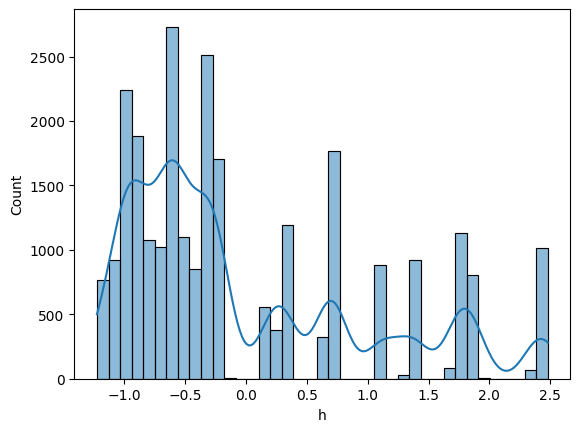

In [11]:
sns.histplot(ds.wtd_df["h"], kde=True)

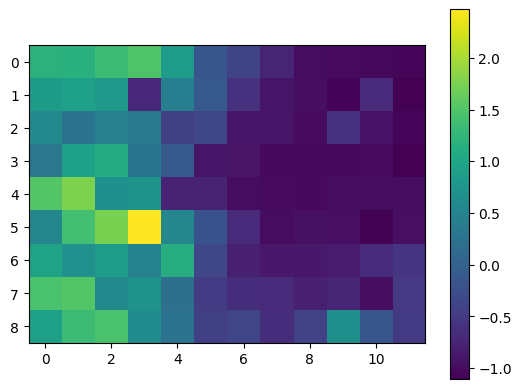

In [12]:
plt.imshow(ds[0][2][0][2,13,:,:])
plt.colorbar()
plt.show()

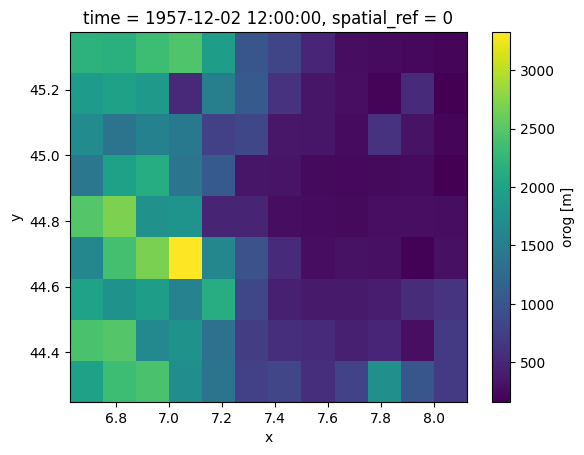

In [13]:
ds.weather_dtm.plot()

In [15]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

In [19]:
import geopy.distance

In [20]:
spatial_resolution_meteo =  geopy.distance.geodesic((ds.weather_xr.lat.values[4],
                               ds.weather_xr.lon.values[0]),
                               (ds.weather_xr.lat.values[5],
                                ds.weather_xr.lon.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_meteo, 5))

Y - Resolution in km:  13.89086


In [22]:
spatial_resolution_dtm =  geopy.distance.geodesic((ds.dtm_roi.y.values[4],
                               ds.dtm_roi.x.values[0]),
                               (ds.dtm_roi.y.values[5],
                                ds.dtm_roi.x.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_dtm, 5))

Y - Resolution in km:  0.09261


# Model 

In [14]:
from models import models_SparseData
importlib.reload(models_SparseData)

<module 'models.models_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/models_SparseData.py'>

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [16]:
from models import load_model
importlib.reload(load_model)

<module 'models.load_model' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model.py'>

In [31]:
model, _ = load_model.load_model(dict_files)

Model: SparseData_Transformer


In [ ]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    
model = model.apply(weight_init)

In [18]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  49474


In [69]:
model.train()
prova_out = model(ds[0][0].unsqueeze(0),
                       ds[0][1].unsqueeze(0),
                       [ds[0][2][0].unsqueeze(0),
                        ds[0][2][1].unsqueeze(0)],
                       ds[0][-2].unsqueeze(0),
                       teacher_forcing = True)

In [20]:
prova_out.shape

torch.Size([26, 28])

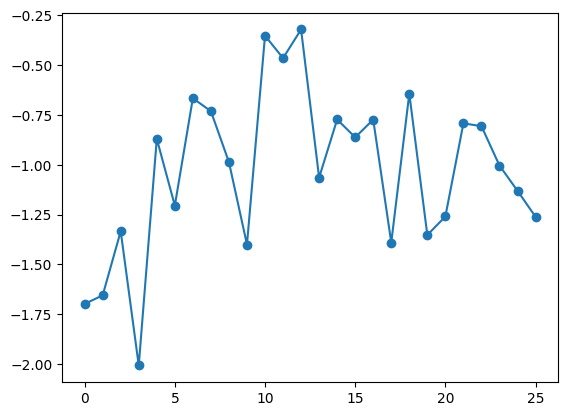

In [37]:
sensor = 5
plt.plot(prova_out[:,sensor].detach().cpu(), marker = "o")

In [38]:
prova_out_eval = model(ds[0][0][0,:,:].unsqueeze(0),
                       ds[0][1].unsqueeze(0),
                       [ds[0][2][0].unsqueeze(0),
                        ds[0][2][1].unsqueeze(0)],
                       ds[0][-2][0,:].unsqueeze(0),
                       teacher_forcing = False)

100%|██████████| 26/26 [00:02<00:00,  9.59it/s]


In [39]:
prova_out_eval.shape

torch.Size([26, 28])

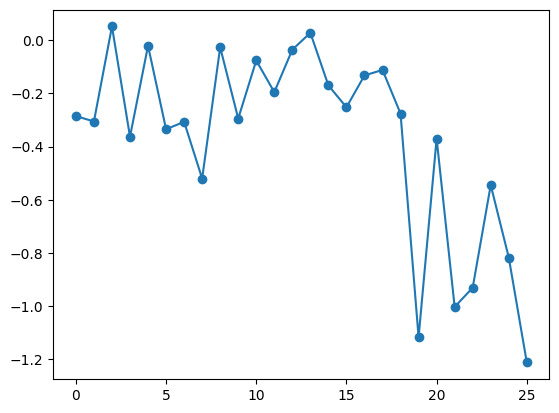

In [40]:
sensor = 5
plt.plot(prova_out_eval[:,sensor].detach().cpu(), marker = "o")

In [25]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

## Grid prediction

In [41]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


In [42]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)

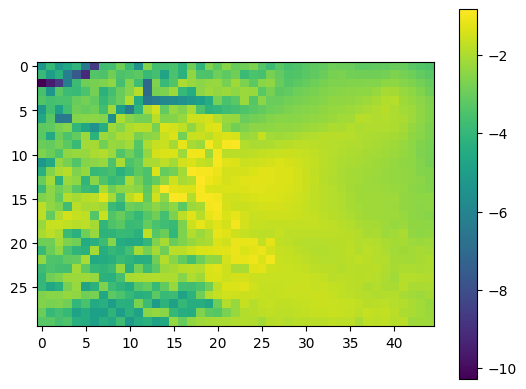

In [43]:
plt.imshow(Y_hat_test_grid[2,:,:])
plt.colorbar()

In [46]:
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

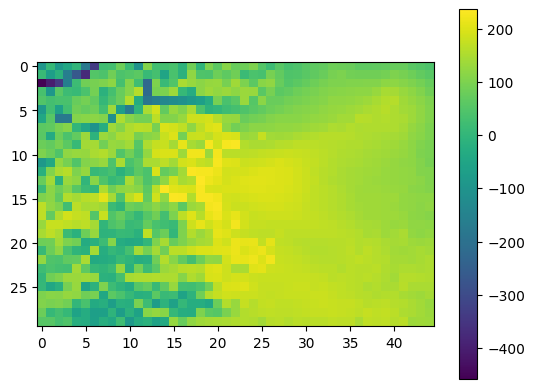

In [47]:
plt.imshow(Y_hat_test_grid[2,:,:])
plt.colorbar()

In [49]:
Y_hat_xr = xarray.DataArray(data = Y_hat_test_grid,
                                coords = dict(
                                            lat=("lat", ((coords[:,0,0] * ds.norm_factors["lat_std"]) + ds.norm_factors["lat_mean"])),
                                            lon=("lon", ((coords[0,:,1] * ds.norm_factors["lon_std"]) + ds.norm_factors["lon_mean"])),
                                            time=pd.date_range(np.datetime64(date),
                                                            np.datetime64(date) + np.timedelta64(twindow-1, dict_files["frequency"]),
                                                            freq = dict_files["frequency"])),
                                dims = ["time","lat", "lon"]
                                )

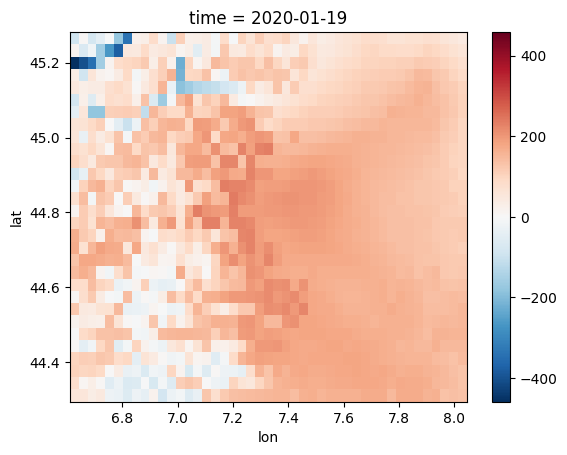

In [52]:
Y_hat_xr[2].plot()

## Load trained model

In [59]:
model_name_path = "model_SparseData_Transformer_20250717_171819" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

SparseData_Transformer(
  (activation_fn): LeakyReLU(negative_slope=0.01)
  (SparseAutoreg_Module): Spatial_Attention_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (topo_embeddings): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (value_embeddings): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (cb_multihead_att_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (norm_linear): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (ST_Conditioning_Module): ST_Conditioning_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (ST_layers): Sequential(
      (0): Li

In [60]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [61]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

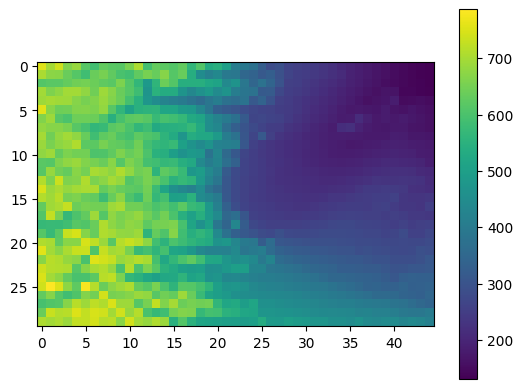

In [66]:
plt.imshow(Y_hat_test_grid[3,:,:])
plt.colorbar()

# Loss

In [84]:
from loss import losses_SparseData
importlib.reload(losses_SparseData)

<module 'loss.losses_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/loss/losses_SparseData.py'>

In [78]:
batch_s = 5
x_batch = torch.stack([ds[i][0] for i in range(batch_s)], dim = 0)
z_batch = torch.stack([ds[i][1] for i in range(batch_s)], dim = 0)
w0_batch = torch.stack([ds[0][2][0] for i in range(batch_s)], dim = 0)
w1_batch = torch.stack([ds[0][2][1] for i in range(batch_s)], dim = 0)
w_batch = [w0_batch, w1_batch]
true_batch = torch.stack([ds[i][-3] for i in range(batch_s)], dim = 0)
xmask_batch = torch.stack([ds[i][-2] for i in range(batch_s)], dim = 0)
ymask_batch = torch.stack([ds[i][-1] for i in range(batch_s)], dim = 0)

In [72]:
model.train()
out_batch = model(x_batch,
                  z_batch,
                  w_batch,
                  xmask_batch,
                       teacher_forcing = True)

In [77]:
out_batch.shape

torch.Size([5, 26, 28])

In [76]:
true_batch.shape

torch.Size([5, 26, 28])

In [87]:
point_h2(out_batch, true_batch, ymask_batch, torch.sum(ymask_batch, dim = 1))

tensor([[1.9094e+03, 0.0000e+00, 0.0000e+00, 2.2233e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.1848e+02, 0.0000e+00, 6.7652e+01, 6.7779e+00, 3.7836e+03,
         0.0000e+00, 0.0000e+00, 7.3086e+01, 3.3701e+02, 2.0609e+01, 0.0000e+00,
         2.2883e+01, 1.7994e+01, 1.7646e+02, 0.0000e+00, 0.0000e+00, 1.8621e+02,
         3.6753e+02, 0.0000e+00, 5.1869e+02, 0.0000e+00],
        [4.3228e+03, 0.0000e+00, 0.0000e+00, 2.0346e+02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.9890e+02, 0.0000e+00, 3.9974e+01, 3.8065e+00, 3.7913e+03,
         0.0000e+00, 0.0000e+00, 7.6249e+01, 1.0300e+03, 4.1789e+01, 0.0000e+00,
         2.0949e+01, 5.4265e+01, 6.2384e+02, 0.0000e+00, 0.0000e+00, 2.1116e+02,
         1.0784e+02, 0.0000e+00, 4.2231e+02, 0.0000e+00],
        [1.1107e+03, 0.0000e+00, 0.0000e+00, 4.7926e+01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.1028e+02, 0.0000e+00, 1.0242e+02, 3.4204e+00, 3.0884e+03,
         0.0000e+00, 0.0000e+00, 8.9599e+01, 4.1762e+03, 2.0330e+01, 0.000

In [86]:
losses_SparseData.loss_masked_h2(out_batch, true_batch, ymask_batch)

tensor(602.4407, grad_fn=<DivBackward0>)

In [85]:
losses_SparseData.loss_masked_nse(out_batch, true_batch, ymask_batch)

tensor(0.0293, grad_fn=<DivBackward0>)